In [204]:
from skimage import measure, filters, color
from skimage.measure import label, regionprops
from Utils import *

In [205]:
def get_horizontal_projection(image):
    return np.sum(image, axis=1)

def get_vertical_projection(image):
    return np.sum(image, axis=0)

In [206]:
def canny_edge_detection(image):
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, gray_image = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)    
    edges = cv.Canny(image, 100, 200)  
    return edges

In [207]:
def crop_whitespace_horizontal_projection(image_path):
    image = cv.imread(image_path)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    thresh = image_gray < np.max(image_gray) * 0.70
    thresh = thresh.astype(int)

    horizontal_projection = np.sum(thresh, axis=1)

    non_white_rows = np.where(horizontal_projection > 0)[0]

    if non_white_rows.size:
        start_row = non_white_rows[0]
        end_row = non_white_rows[-1]
        
        cropped_image = image[start_row:end_row+1]
    else:
        cropped_image = image 
        
    return cropped_image


In [208]:
def deskew_text_image(img):
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.GaussianBlur(img, (9, 9), 0)

    resized_height = 480
    percent = resized_height / len(img)
    resized_width = int(percent * len(img[0]))
    
    gray = cv.resize(img,(resized_width,resized_height))
    
    start_point = (0, 0) 
    end_point = (gray.shape[0], gray.shape[1]) 
    color = (255, 255, 255) 
    thickness = 10
    gray = cv.rectangle(gray, start_point, end_point, color, thickness)
    gray = cv.bitwise_not(gray)
 
    thresh = cv.threshold(gray, 0, 255,
        cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (30, 5))
    dilate = cv.dilate(thresh, kernel)
    
    contours, hierarchy = cv.findContours(dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    angles = []
    for contour in contours:
        minAreaRect = cv.minAreaRect(contour)
        angle = minAreaRect[-1]
        if angle != 90.0 and angle != -0.0: #filter out 0 and 90
            angles.append(angle)
    
    if len(angles) == 0:
        return img
    
    angles.sort()
    mid_angle = angles[int(len(angles)/2)]    
    
    if angle > 45: #anti-clockwise
        angle = -(90 - angle)
    height = img.shape[0]
    width = img.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    deskewed = cv.warpAffine(img, m, (width, height), borderValue=(255,255,255))
    
    return deskewed

In [209]:
def extract_text_regions(edge_image):
    binary_image = np.array(edge_image) > 128
    label_image = label(binary_image)
    regions = regionprops(label_image)

    bounding_boxes = [region.bbox for region in regions if region.area > 50]  
    return bounding_boxes

In [210]:
#merge bounding boxes that are close to each other
def merge_bounding_boxes(bounding_boxes, proximity_threshold=10, line_height=0):
    merged_boxes = []
        
    # Sort bounding boxes by their top-left x-coordinate
    bounding_boxes.sort(key=lambda box: box[1])

    for box in bounding_boxes:
        merged = False
        for merged_box in merged_boxes:
            if  ((box[3] <= merged_box[1]) or (abs(box[3] - merged_box[1]) <= proximity_threshold)) and abs(box[0] - merged_box[0]) <= line_height :
                # Merge the boxes horizontally
                new_box = (min(merged_box[0], box[0]),  
                           min(merged_box[1], box[1]),
                            max(merged_box[2], box[2]),
                           max(merged_box[3], box[3]))
                merged_boxes.remove(merged_box)
                merged_boxes.append(new_box)
                merged = True
                break
        if not merged:
            merged_boxes.append(box)
    
    return merged_boxes


In [211]:
def segment_lines(binary_image, dots_image):
    original_image = binary_image.copy()
    dots_image_copy = dots_image.copy()
    
    horizontal_projection = get_horizontal_projection(binary_image)

    line_indices = np.where(horizontal_projection > 0)[0]
    if not line_indices.size:
        return []  

    lines = []
    dots_lines = []
    start_idx = line_indices[0]
    for i in range(1, len(line_indices)):
        if line_indices[i] - line_indices[i - 1] > 1:  # Found a gap between lines
            end_idx = line_indices[i - 1]
            
            line_image = binary_image[start_idx:end_idx + 1]
            lines.append(line_image)
            
            dots_line_image = dots_image[start_idx:end_idx + 1]
            dots_lines.append(dots_line_image)
            
            start_idx = line_indices[i]
            #draw the bounding box of the line on the binary image
            original_image = cv.rectangle(original_image, (0, start_idx), (original_image.shape[1], end_idx), (255, 255, 255), 2)

    # Add the last line
    if start_idx <= line_indices[-1]:
        end_idx = line_indices[-1]
        
        line_image = binary_image[start_idx:end_idx + 1]
        lines.append(line_image)
        
        dots_line_image = dots_image[start_idx:end_idx + 1]
        dots_lines.append(dots_line_image)
        
        #draw the bounding box of the line on the binary image
        original_image = cv.rectangle(original_image, (0, start_idx), (original_image.shape[1], end_idx), (255, 255, 255), 2)

    
    # Create a list of indices where lines are not empty
    indices_to_keep = [i for i, line in enumerate(lines) if np.sum(line) > 0]

    # Filter both dots_lines and lines using the indices_to_keep
    dots_lines = [dots_lines[i] for i in indices_to_keep]
    lines = [lines[i] for i in indices_to_keep]

    return lines, dots_lines

In [212]:
def get_average_line_height(lines):
    line_heights = []
    for line in lines:
        line_heights.append(line.shape[0])
        
    mean = np.mean(line_heights)
    return mean

In [213]:
def get_proximity_threshold(line):
    if len(line.shape) == 3:
        line = cv.cvtColor(line, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(line, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    
    # Compute vertical projection
    vertical_projection = get_vertical_projection(binary_image)

    gap_indices = np.where(vertical_projection == 0)[0]
    if gap_indices.size <= 1:
        #get the minimum values of the vertical projection
        min_vertical_projection = np.min(vertical_projection)
        gap_indices = np.where(vertical_projection == min_vertical_projection)[0]
        
    gap_widths = np.diff(gap_indices)
   
    #remove extreme high outliers
    gap_widths = gap_widths[gap_widths < np.percentile(gap_widths, 90)]

    # set proximity threshold to upper median of gap widths
    proximity_threshold = abs(np.median(gap_widths) - np.std(gap_widths))
    
    return proximity_threshold

In [214]:
def trial_words(lines, line_height):
    for i, line in enumerate(lines):
        #save_words([line], 'line_' + str(i), 'D:/UNI/CCE_sem_8_LAST_YAY_^^/gp2/project/graduation_project-Ocr_module/trial_lines')
        if np.all(line == 0):
            continue        
            
        edge_image = canny_edge_detection(line)
        show_images([edge_image], ['Edge Image'])
        
        bounding_boxes = extract_text_regions(edge_image)
        
        proximity_threshold = get_proximity_threshold(line)
        
        merged_boxes = merge_bounding_boxes(bounding_boxes, proximity_threshold, line_height)
        
        plot_text_regions(line, merged_boxes)
        
        words = [line[0:line.shape[1], box[1]:box[3]] for box in merged_boxes]
        

In [215]:

def save_words(words, file_name, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, word in enumerate(words):
        cv.imwrite(f'{output_dir}/{file_name}_word_{i}.png', word)

In [216]:
def process_lines(lines, average_height, dots_lines):
    new_lines = []
    new_dots_lines = []
    for i, line in enumerate(lines):
        dots_line = dots_lines[i]
        if line.shape[0] > average_height * 2:
            lines.pop(i)
            dots_lines.pop(i)           
             
            deskewed_line = deskew_text_image(line)           
            horizontal_proj = get_horizontal_projection(deskewed_line)
    
            #min peaks is the smallest 10% of the peaks
            threshhold = np.percentile(horizontal_proj, 10)
            min_peaks = horizontal_proj[horizontal_proj <= threshhold]
            min_peaks_indices = [i for i, peak in enumerate(horizontal_proj) if peak in min_peaks]
            #if there are conitnuous min peaks, get the median of the conitnuous peaks
            cont_array =[]
            new_min_peaks_indices = []
            for j in range(1, len(min_peaks_indices)):
                if min_peaks_indices[j] - min_peaks_indices[j-1] == 1:
                    cont_array.append(min_peaks_indices[j-1])
                    cont_array.append(min_peaks_indices[j])
                else:
                    if len(cont_array) > 0:
                        median = np.median(cont_array)
                        #remove all the continuous indices and add the median
                        new_min_peaks_indices.append(median)
                        cont_array = []
                    else:
                        new_min_peaks_indices.append(min_peaks_indices[j-1])
                    
            resplit_lines = []
            resplit_dots_lines = []
            if len(min_peaks_indices) == 0:
                continue
            elif len(min_peaks_indices) == 1:
                split_index = min_peaks_indices[0]
                resplit_lines.append(deskewed_line[:split_index, :])
                resplit_dots_lines.append(dots_line[:split_index, :])
                
                resplit_lines.append(deskewed_line[split_index:, :])
                resplit_dots_lines.append(dots_line[split_index:, :])
            else:
                resplit_lines.append(deskewed_line[:min_peaks_indices[0], :])
                resplit_dots_lines.append(dots_line[:min_peaks_indices[0], :])
                
                for i, split_index in enumerate(min_peaks_indices):
                    if i == len(min_peaks_indices) -1:
                        resplit_lines.append(deskewed_line[split_index:, :])
                        resplit_dots_lines.append(dots_line[split_index:, :])
                    else:
                        resplit_lines.append(deskewed_line[split_index: min_peaks_indices[i+1], :])
                        resplit_dots_lines.append(dots_line[split_index: min_peaks_indices[i+1], :])
                        
            new_lines.extend(resplit_lines)
            new_dots_lines.extend(resplit_dots_lines)
        else:
            new_lines.append(line)
            new_dots_lines.append(dots_line)
    
    # Create a list of indices where lines are not empty
    indices_to_keep = [i for i, line in enumerate(new_lines) if line.shape[0] > 10]

    # Filter both dots_lines and lines using the indices_to_keep
    new_dots_lines = [new_dots_lines[i] for i in indices_to_keep]
    new_lines = [new_lines[i] for i in indices_to_keep]
    
    return new_lines, new_dots_lines
            

In [217]:
def find_zero_segments(vertical_projection):
    zero_segments = []
    in_zero_segment = False
    start_index = None
    
    for i, value in enumerate(vertical_projection):
        if value == 0:
            if not in_zero_segment:
                in_zero_segment = True
                start_index = i
        else:
            if in_zero_segment:
                # We're exiting a zero segment
                zero_segments.append((start_index, i - 1))
                in_zero_segment = False

    # Check if the last segment in the array was a zero segment
    if in_zero_segment:
        zero_segments.append((start_index, len(vertical_projection) - 1))
    
    return zero_segments

In [218]:
def extract_words_from_segments(vertically_cropped_line, filtered_areas):
    words = []
    bounding_boxes = []
    
    #append the first word
    first_word = vertically_cropped_line[:, :filtered_areas[0][0]]    
    words.append(first_word)
    bounding_boxes.append((0, 0, filtered_areas[0][0], vertically_cropped_line.shape[0]))
    
    for i in range(len(filtered_areas) - 1):
        # Get the end index of the current segment and the start index of the next segment
        current_end = filtered_areas[i][1]
        next_start = filtered_areas[i + 1][0]
        
        # Extract the part of the image between these indices
        word = vertically_cropped_line[:, current_end:next_start]
        bounding_boxes.append((current_end, 0, next_start, vertically_cropped_line.shape[0]))
        words.append(word)
        
    
    #append the last word
    last_word = vertically_cropped_line[:, filtered_areas[-1][1]:]
    words.append(last_word)
    bounding_boxes.append((filtered_areas[-1][1], 0, vertically_cropped_line.shape[1], vertically_cropped_line.shape[0]))
    
    #make sure none of the words is all black pixels
    words = [word for word in words if np.sum(word) > 0]
    return words, bounding_boxes

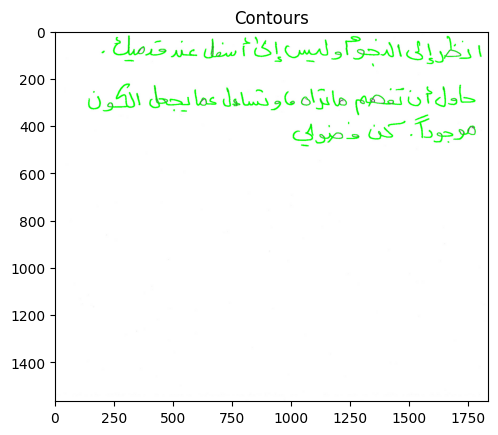

In [219]:
def get_contours(image):
    return cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

In [220]:
def fill_contours(image, contours):
    percntile_40 = np.percentile([cv.contourArea(contour) for contour in contours], 30)
    #get contours that are too small
    small_contours = [contour for contour in contours if cv.contourArea(contour) < percntile_40]
    new_image = np.zeros_like(image)
    #fill the small contours with black
    for contour in small_contours:
        #remove the small contours by filling them with black
        image = cv.drawContours(image, [contour], 0, (0, 0, 0), -1)
        #add the removed contours to a new image
        dots_image = cv.drawContours(new_image, [contour], 0, (250, 250, 250), 3)        
    return image, dots_image

In [221]:
def segment(path):
    original_image = crop_whitespace_horizontal_projection(path)
    
    #opening
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    image = cv.morphologyEx(original_image, cv.MORPH_OPEN, kernel)

    #closing
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    image = cv.morphologyEx(original_image, cv.MORPH_CLOSE, kernel)

    #opening
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    image = cv.morphologyEx(original_image, cv.MORPH_OPEN, kernel)

    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    contours = get_contours(binary_image)

    binary_image_filled, dots_image = fill_contours(binary_image, contours)

    lines, dots_lines = segment_lines(binary_image_filled, dots_image)
    
    #remove lines that are too small
    dots_lines = [dots_line for dots_line, line in zip(dots_lines, lines) if line.shape[0] > 20]  # Remove empty lines
    lines = [line for line in lines if line.shape[0] > 20]
    
    line_height = get_average_line_height(lines)
        
    lines, dots_lines = process_lines(lines, line_height, dots_lines)
    
    output = []
    for i, line in enumerate(lines):
        vertical_projection = get_vertical_projection(line)
        
        vertically_cropped_line = line
        
        #check if the image starts and ends with black space, if so remove that part of the line
        if vertical_projection[0] == 0:
            #get the first index where the value is not 0
            start_index = np.where(vertical_projection != 0)[0][0]
            vertically_cropped_line = line[:, start_index:]
            dots_lines[i] = dots_lines[i][:, start_index:]
            vertical_projection = get_vertical_projection(vertically_cropped_line)
            
        zero_segments = find_zero_segments(vertical_projection)
        average_area = np.mean([end - start for start, end in zero_segments])
    
        filtered_areas = [(start , end) for start, end in zero_segments if end - start > average_area or end - start > 0.65 * average_area]
        
        words, word_box = extract_words_from_segments(vertically_cropped_line, filtered_areas)    
        
        vertically_cropped_line = cv.bitwise_or(vertically_cropped_line, dots_lines[i])
        
        #extract the words bounded by the boxes from vertically cropped line into a new list of words
        new_words = [vertically_cropped_line[:, box[0]:box[2]] for box in word_box]
        new_words = [word for word in new_words if np.sum(word) > 0]
        
        output.append((vertically_cropped_line, new_words))
    return output
  

In [222]:
def segment_save_lines_words(path, parag_num='', user_num=''):

    segmented_picture = segment(path)
    
    return segmented_picture

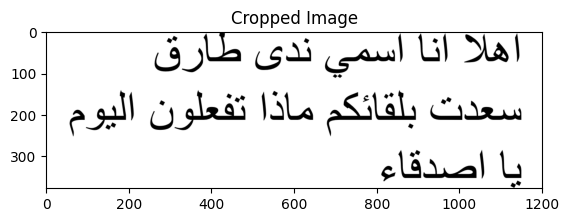

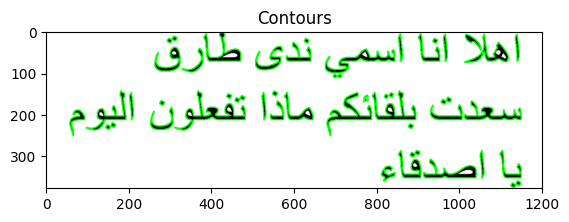

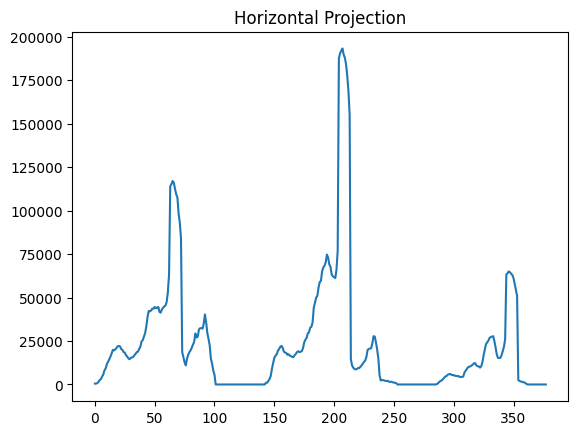

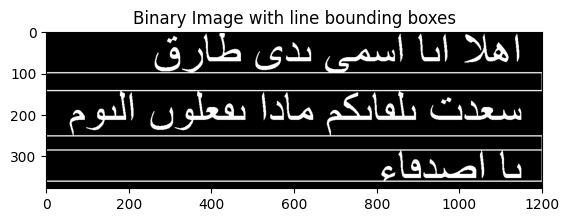

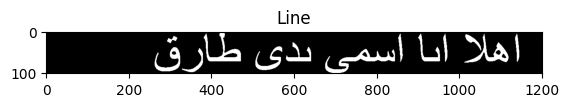

(101, 1201)


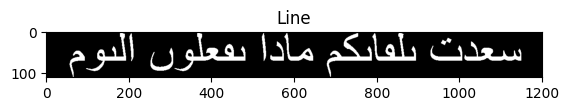

(110, 1201)


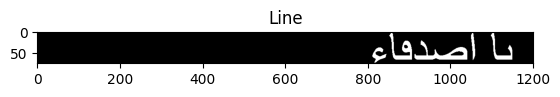

(76, 1201)


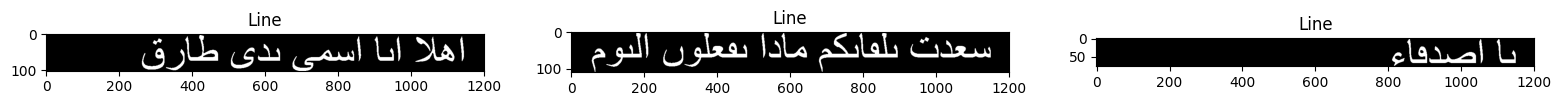

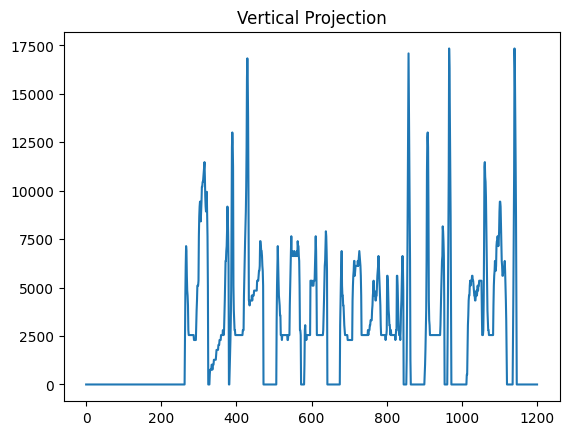

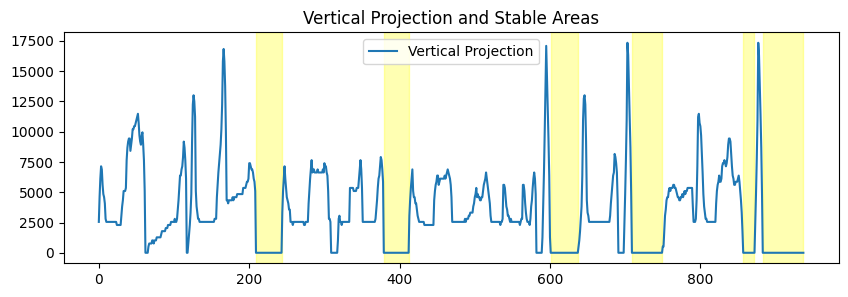

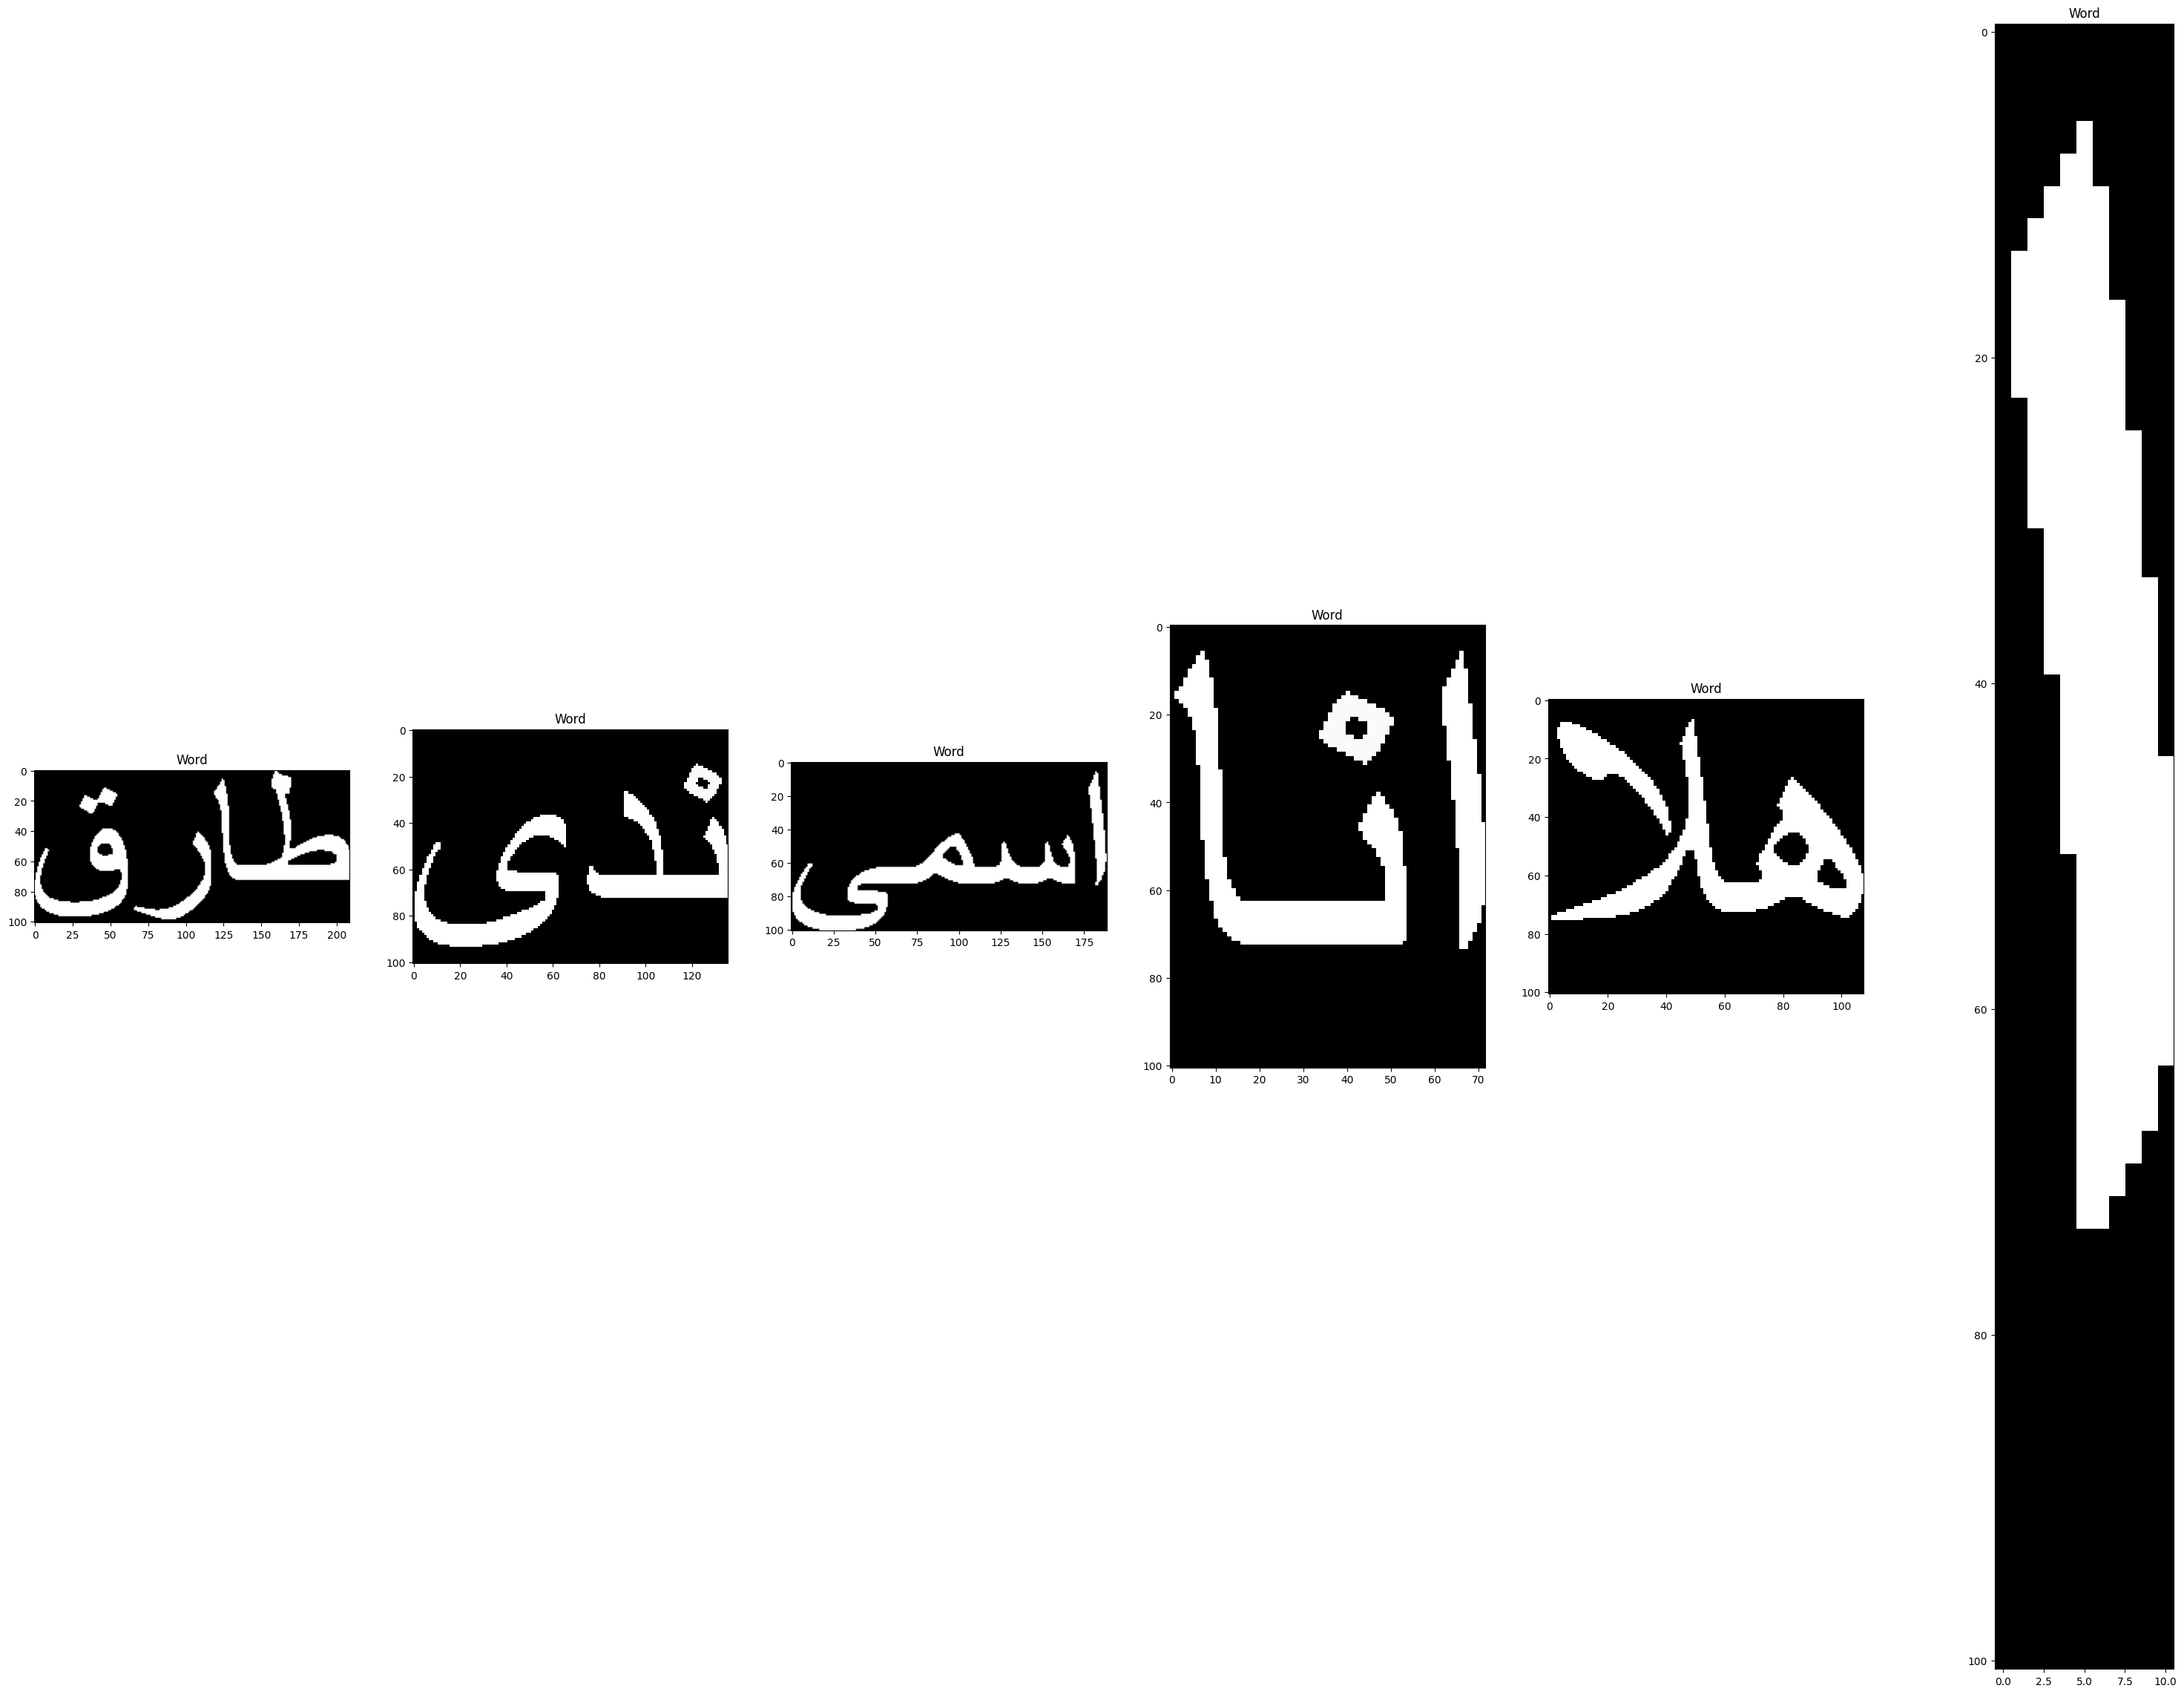

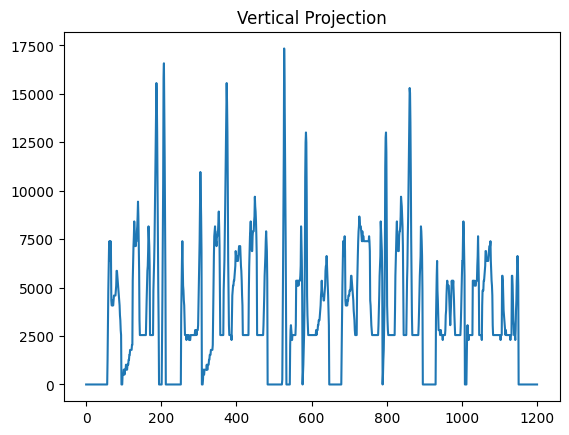

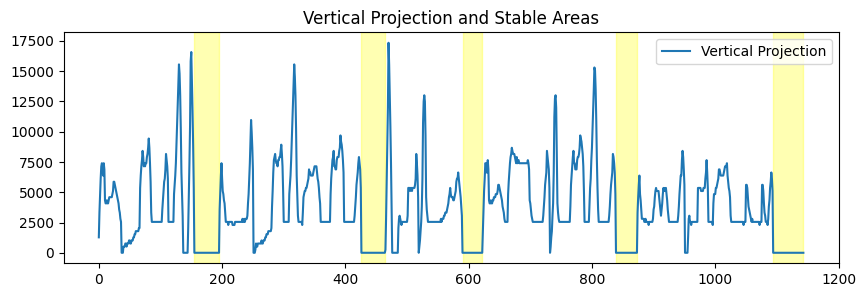

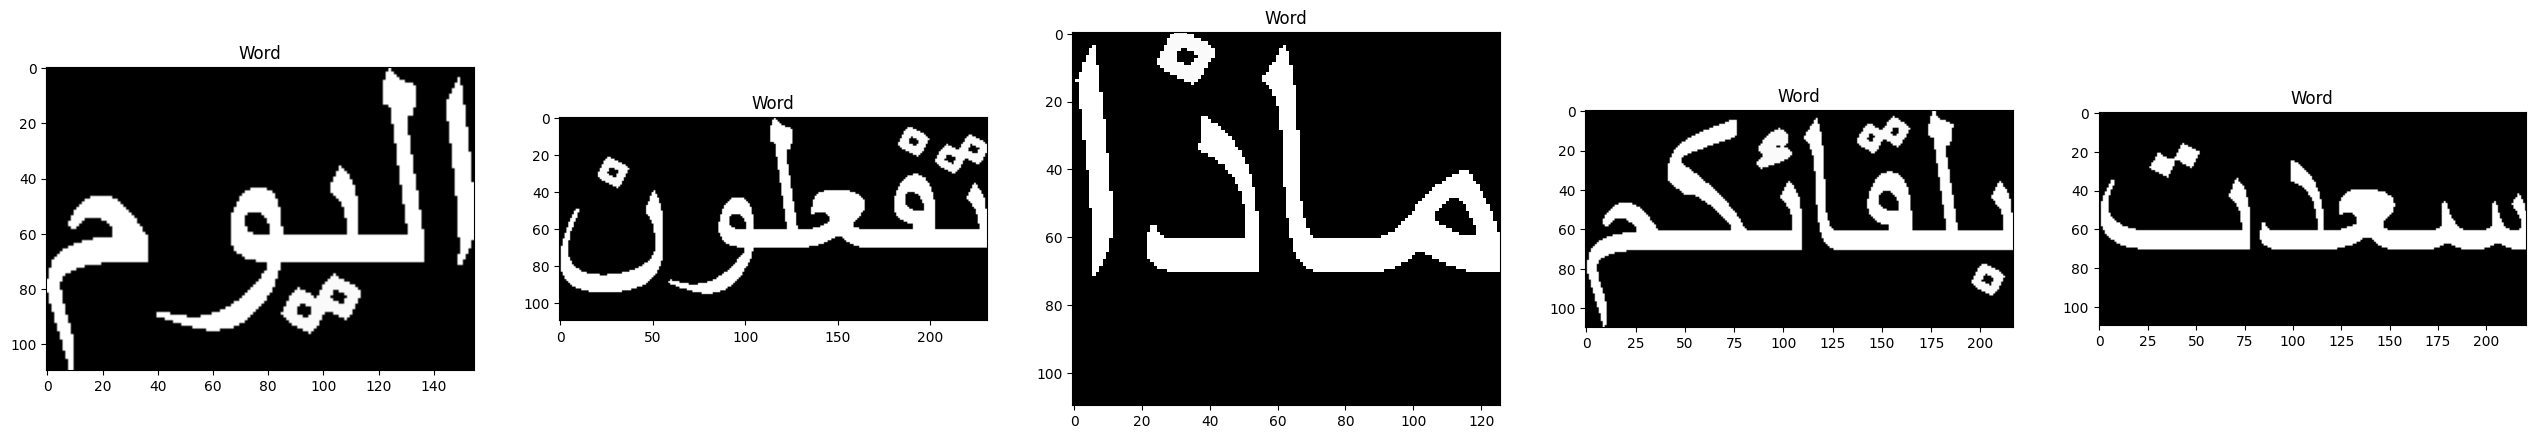

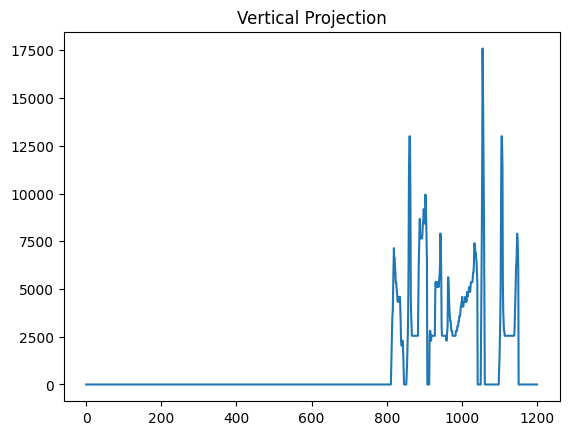

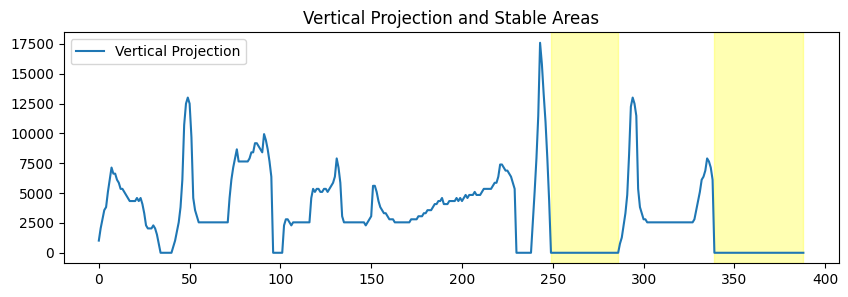

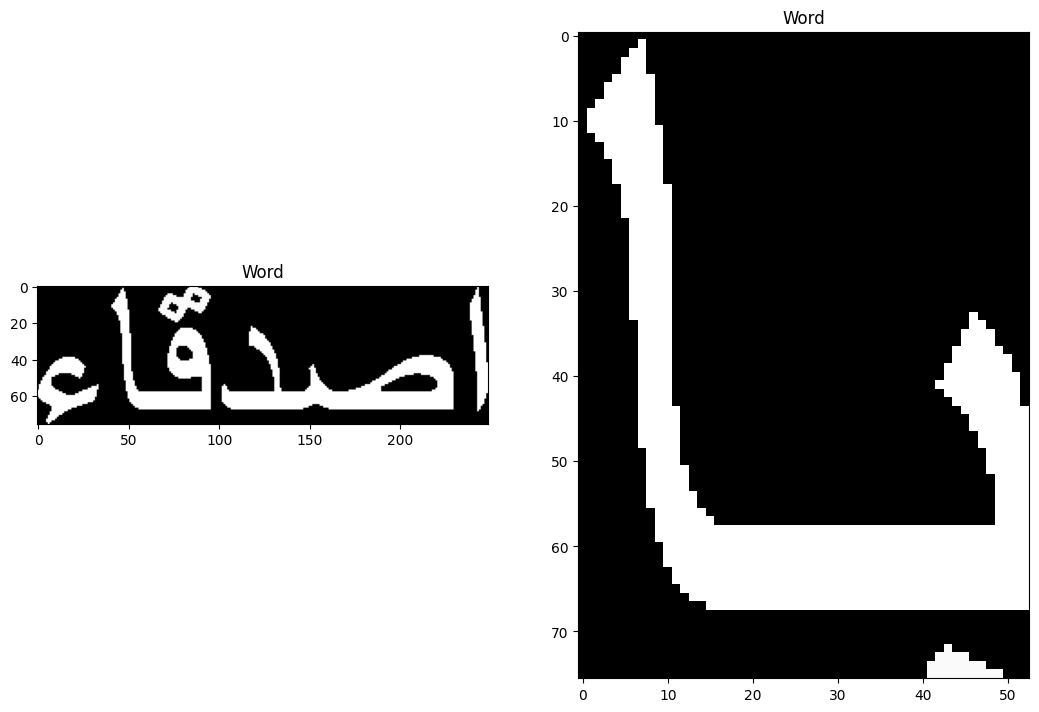

[(array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  [array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   array([[0, 0, 0, ..., 0, 0, 0],
          [0

In [223]:
# path = 'D:/UNI/CCE_sem_8_LAST_YAY_^^/gp2/project/Alfarahifi_org/arabic-ocr/paragraphs_per_user/paragraphs_per_user/user001/com_paragraph.png'

# segment_save_lines_words(path, '0', '001')